In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

templist = [5, 10, 15, 20, 25, 30, 35, 40]
#templist = [-9.4, -4.4, 0.4, 5.3, 10.3, 15.3, 20, 25, 30, 35, 40]
badchannels = [18, 29, 37, 38, 44, 58]
runlist = [
#           [1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595],
#           [1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582],
#           [1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569],
           [1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556],    
           [1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542],  
           [1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525],
           [1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1493],
           [1433, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442],
           [1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451],
           [1457, 1458, 1459, 1460, 1461 ,1462, 1463, 1464, 1465],
           [1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506]   
          ]
        
        
bias = np.array([
#                 [51.6, 52.1, 52.6, 53.1, 53.6, 54.1, 54.6, 55.1, 55.6],
#                 [51.9, 52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9],
#                 [52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2],
                 [52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9, 56.4],
                 [52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7],
                 [53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0],
                 [53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7, 57.2],
                 [53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8],
                 [54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0],
                 [54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8, 58.3]
                ])

In [2]:
def processTemperature(arr, idx):

    df = pd.DataFrame(columns=['chan', 'slope', 'temp', 'intercept', 'r_value', 'p_value', 'std_err', 
                               'Vbd', 'spe_3V_over', 'spe_54V_fix', 'spe_55V_fix', 'spe_60V_fix', 'spe_65V_fix'])

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%templist[idx])

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("PE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias[idx]
            y=arSPE[:, 0, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d"%(chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)
            spe_3V_over = slope*(ratio + 3)+intercept

            new_row = {'chan': chan, 'slope': slope, 'temp': temp, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio, 
                       'spe_3V_over': spe_3V_over, 'spe_54V_fix': slope*54+intercept,
                       'spe_55V_fix': slope*55+intercept, 'spe_60V_fix': slope*60+intercept, 'spe_65V_fix': slope*65+intercept}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept, slope, ratio))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');
    return df

Bad channel: 58


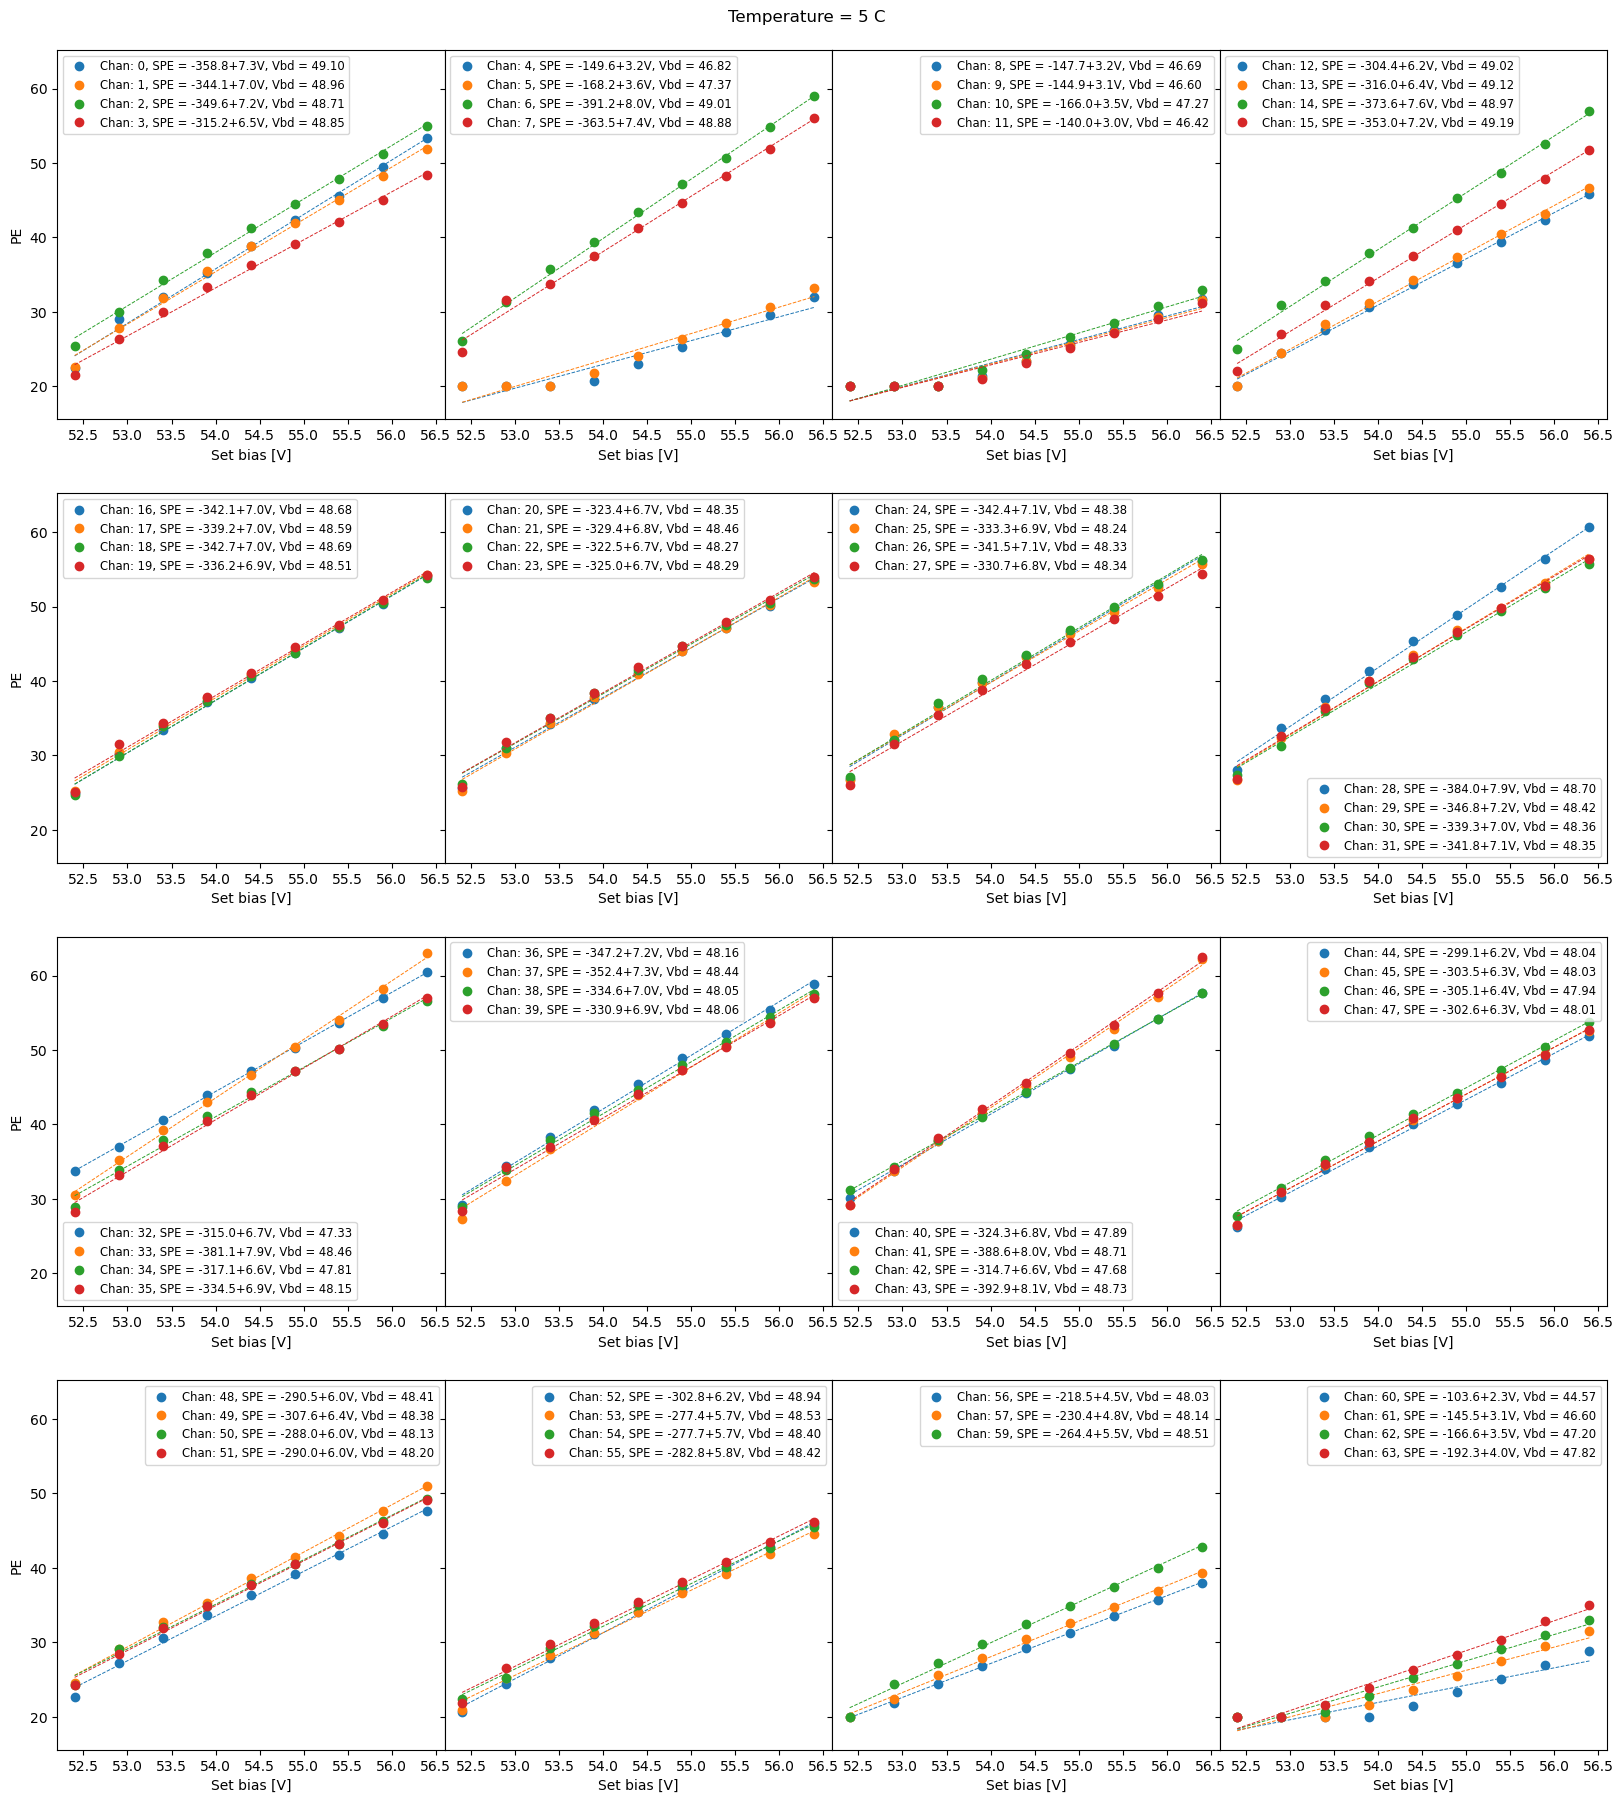

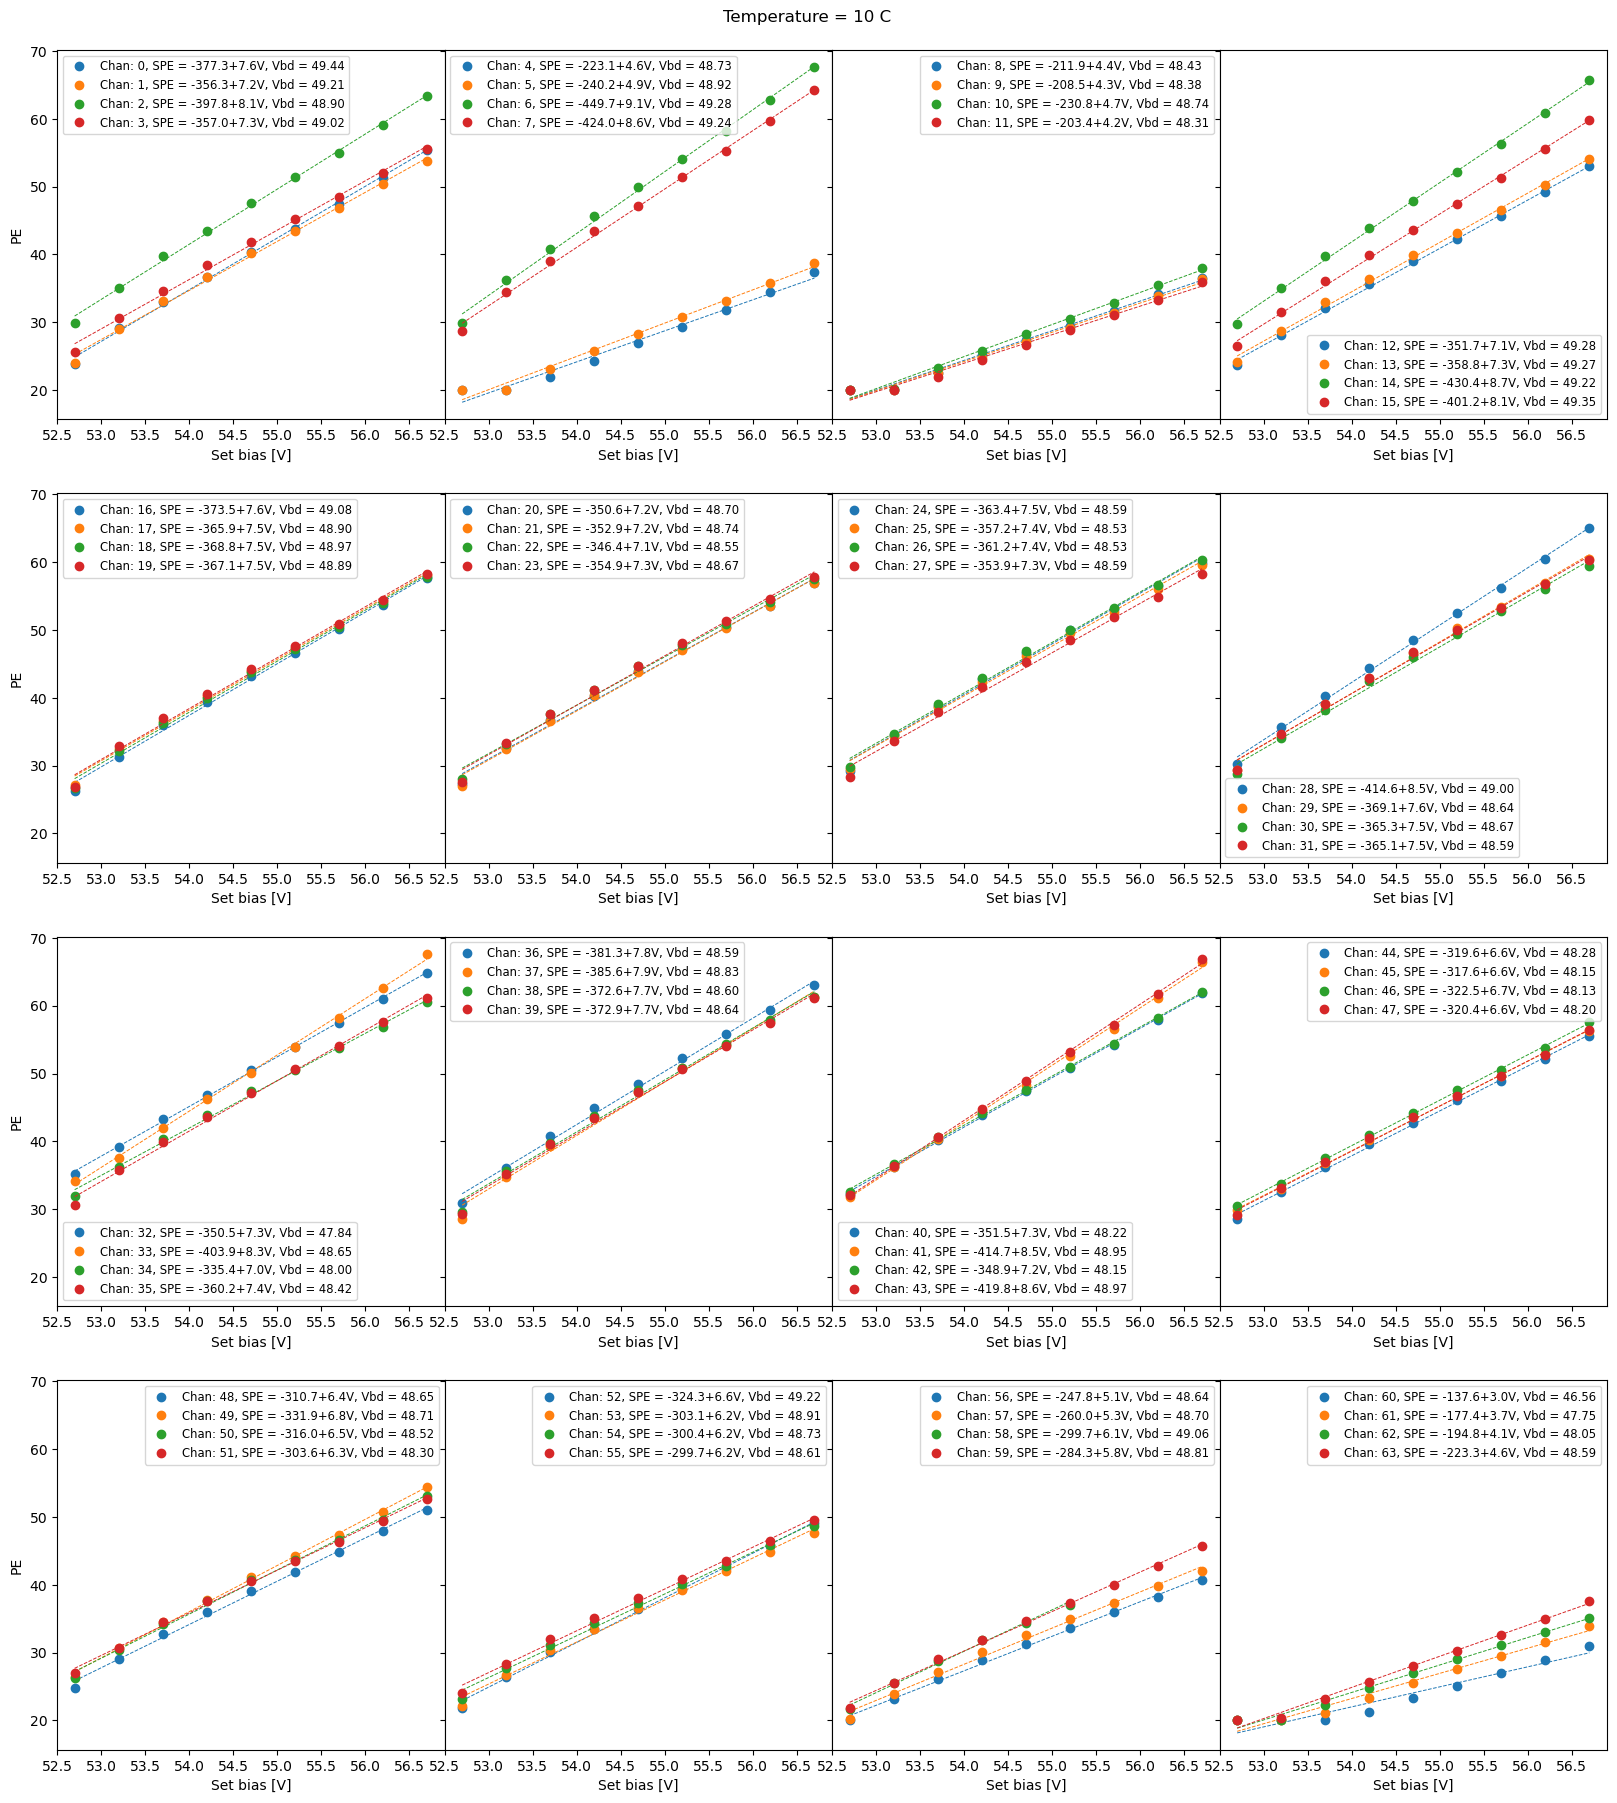

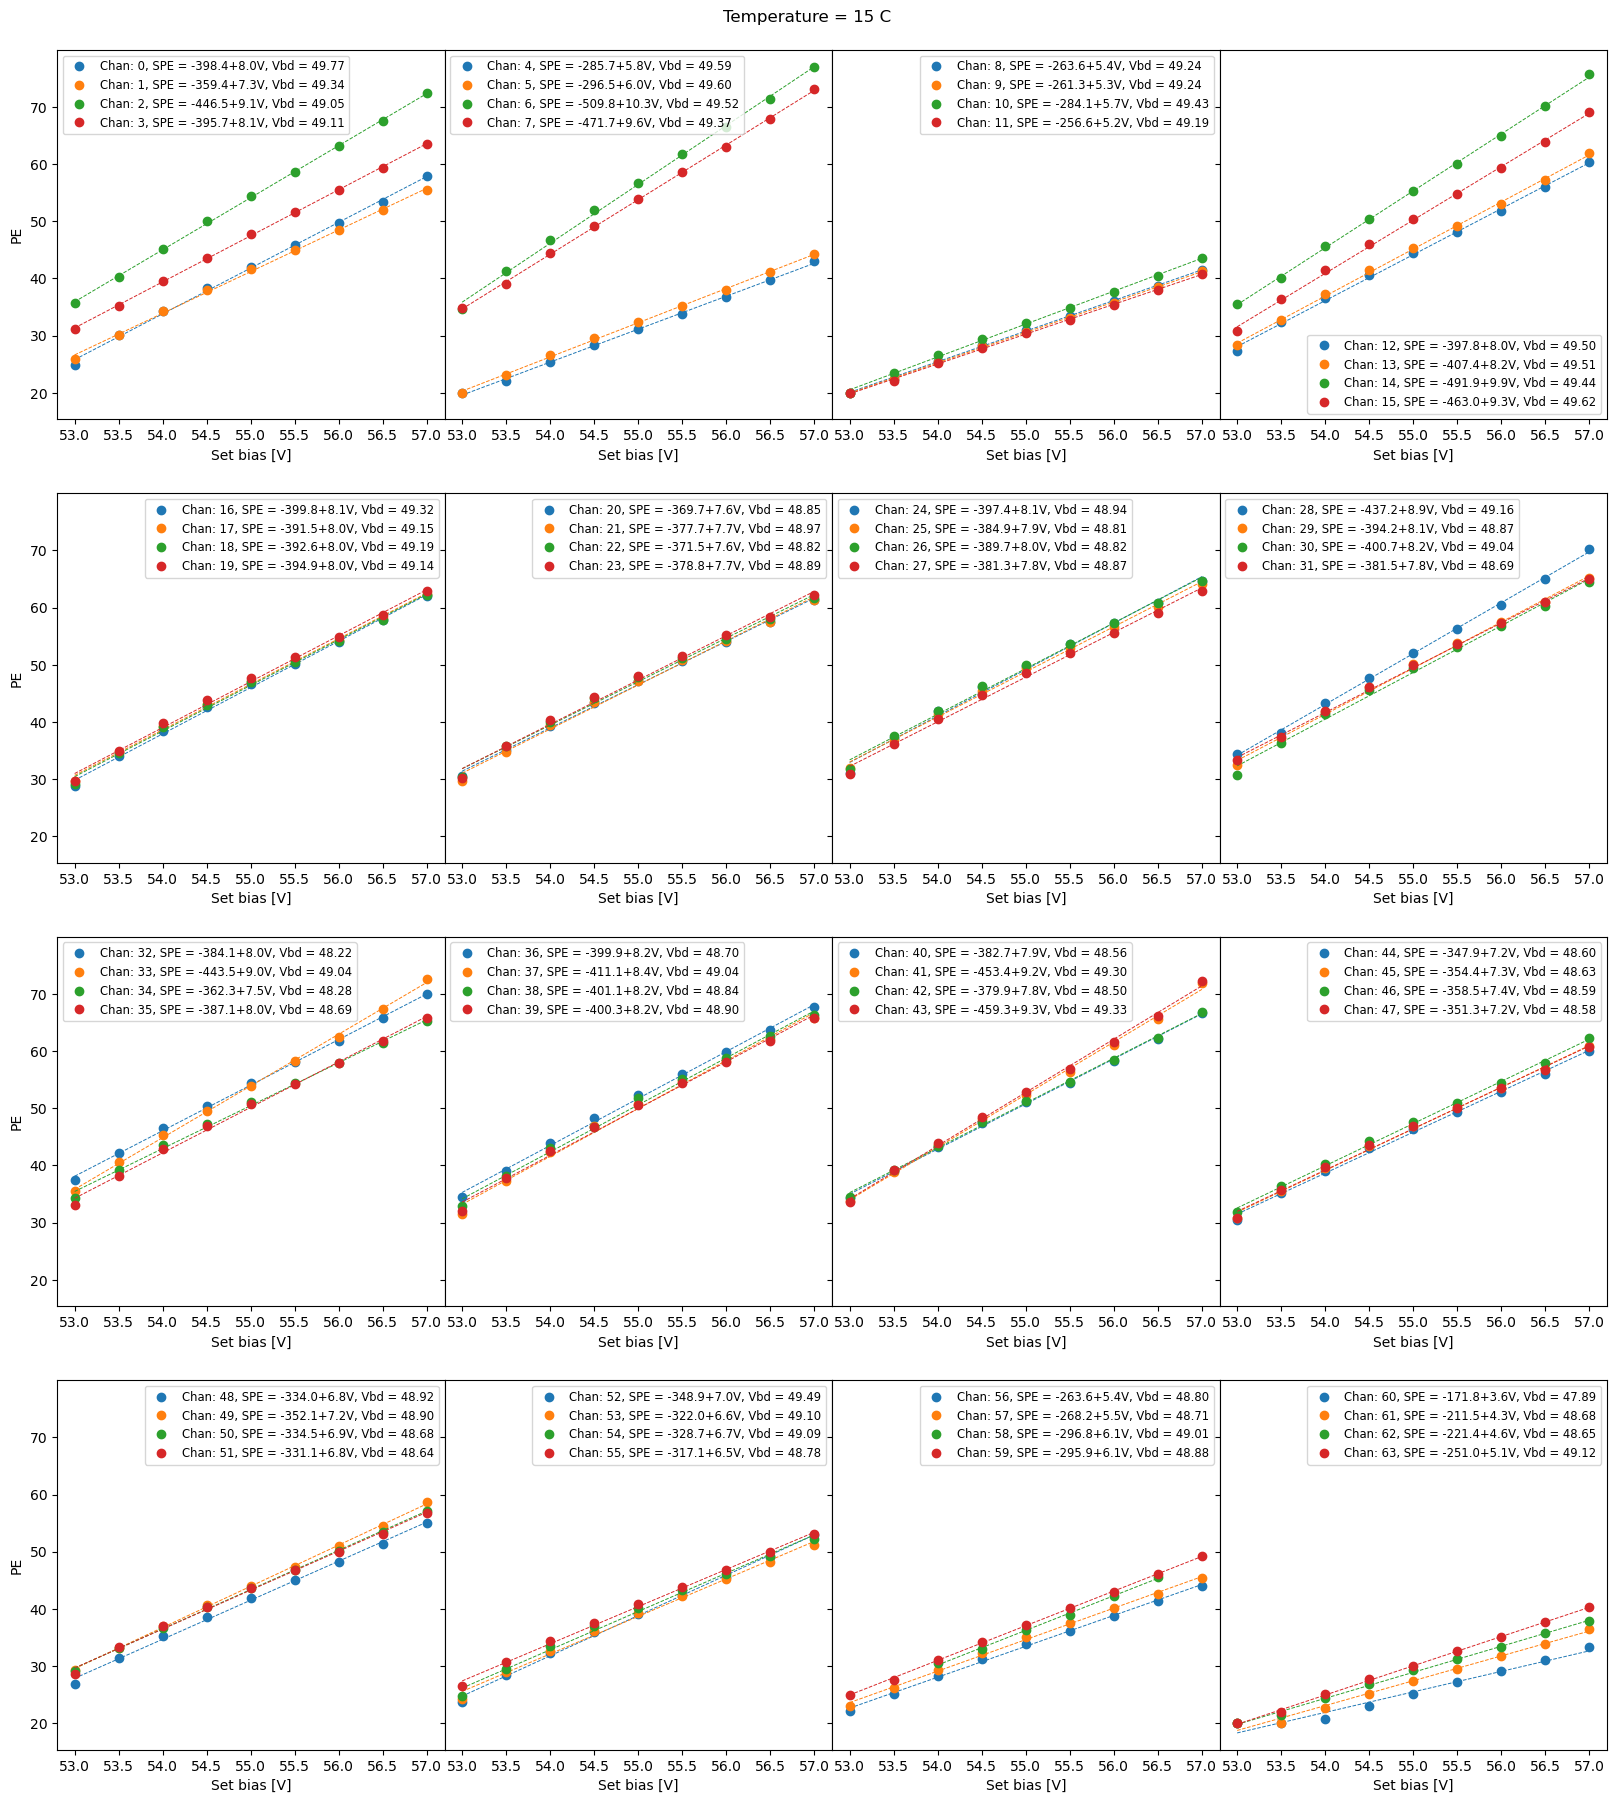

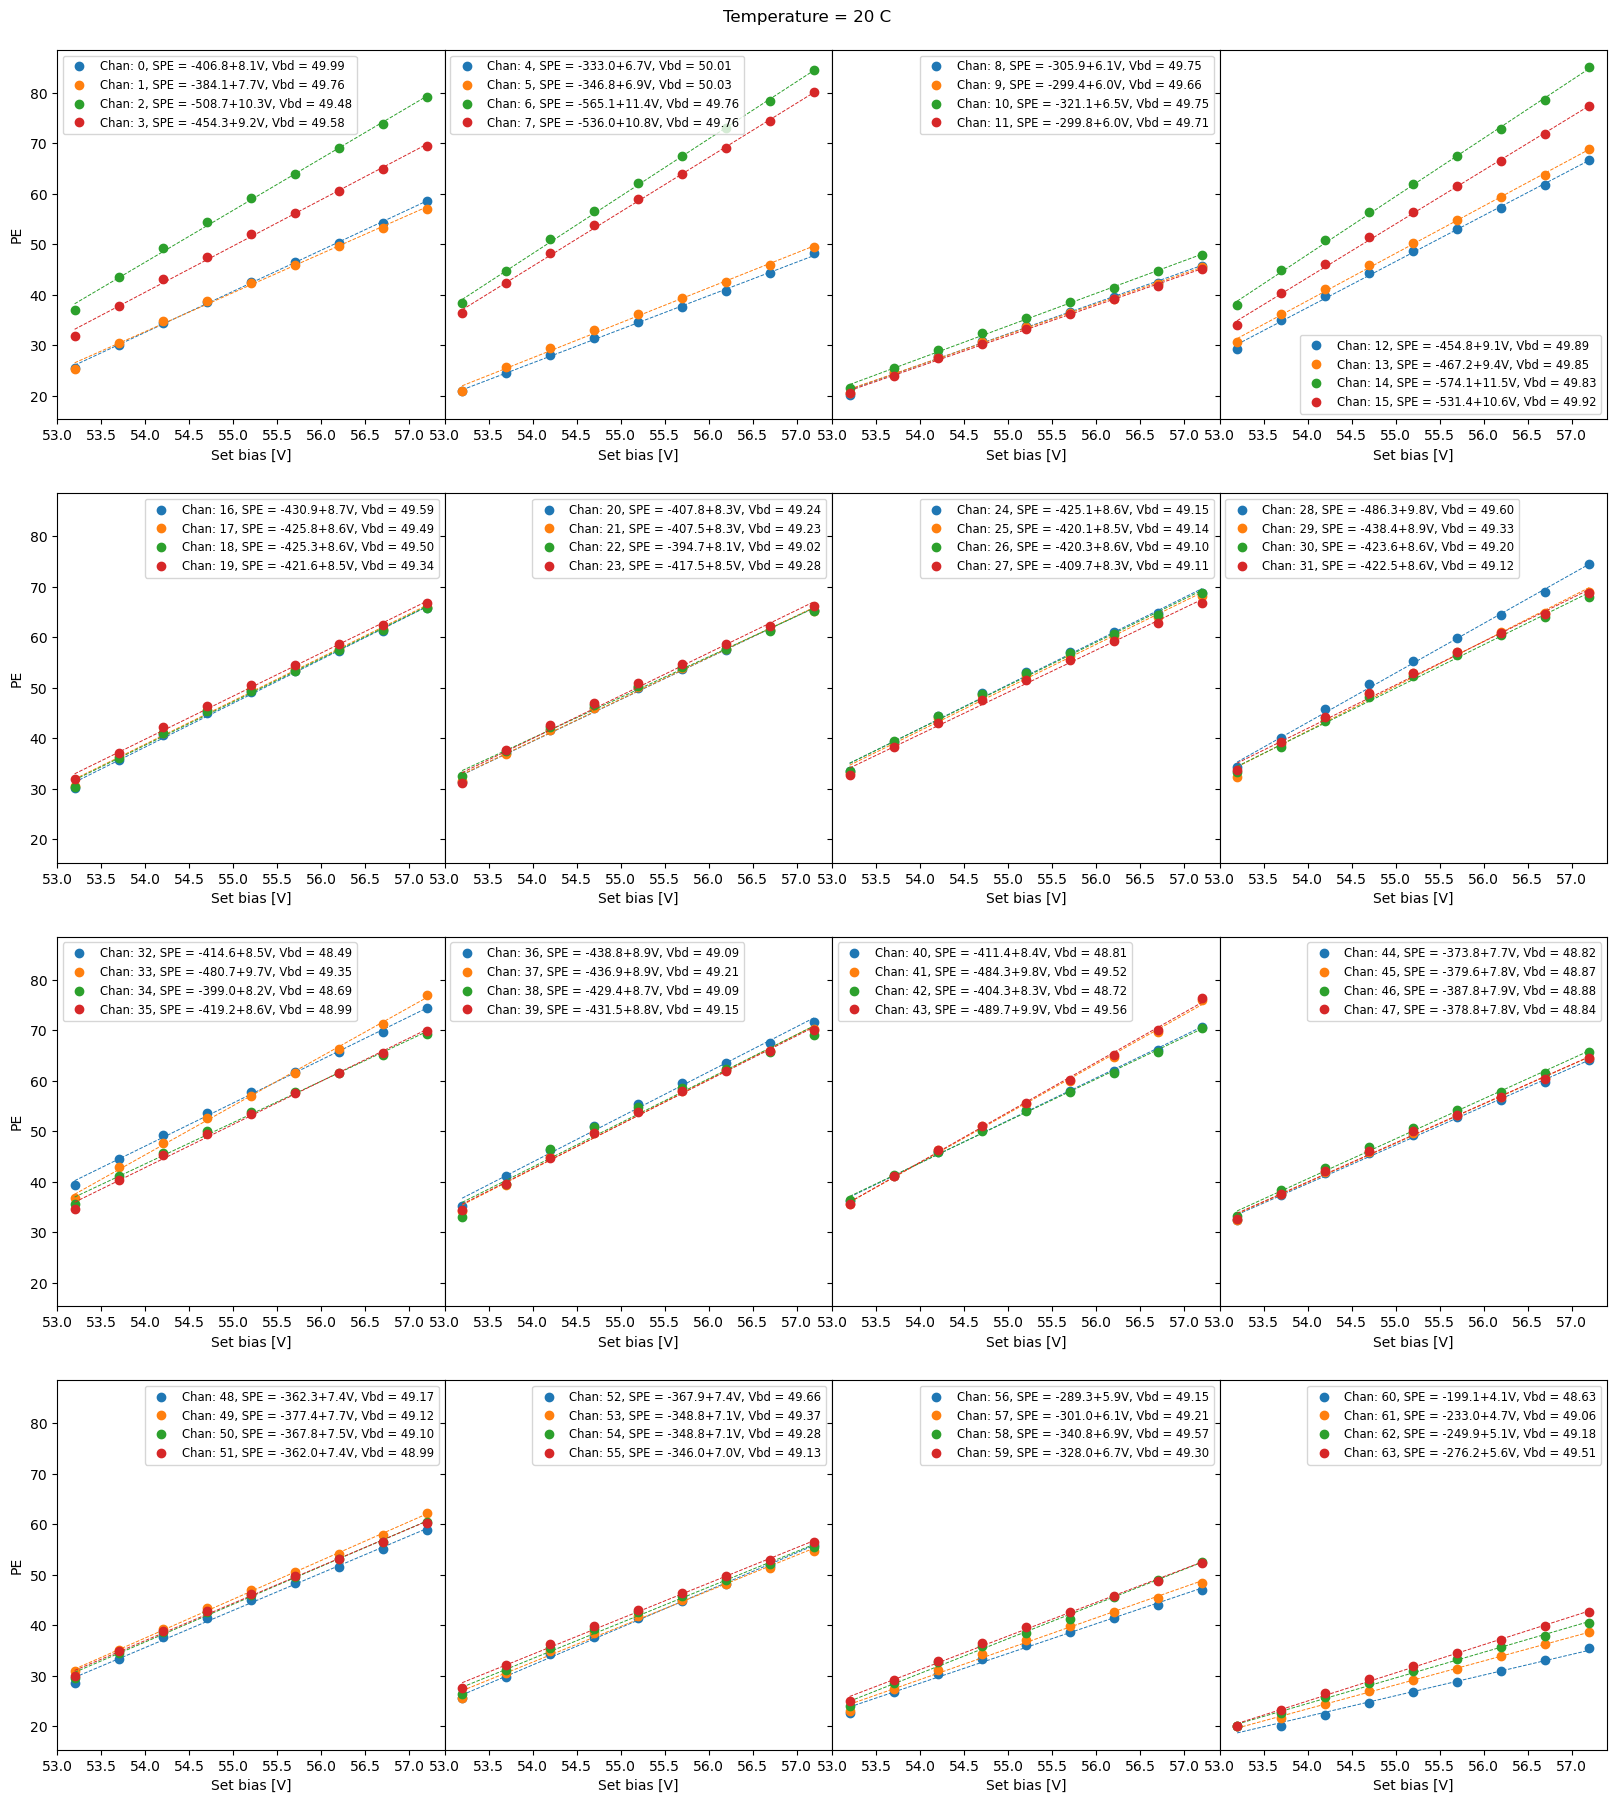

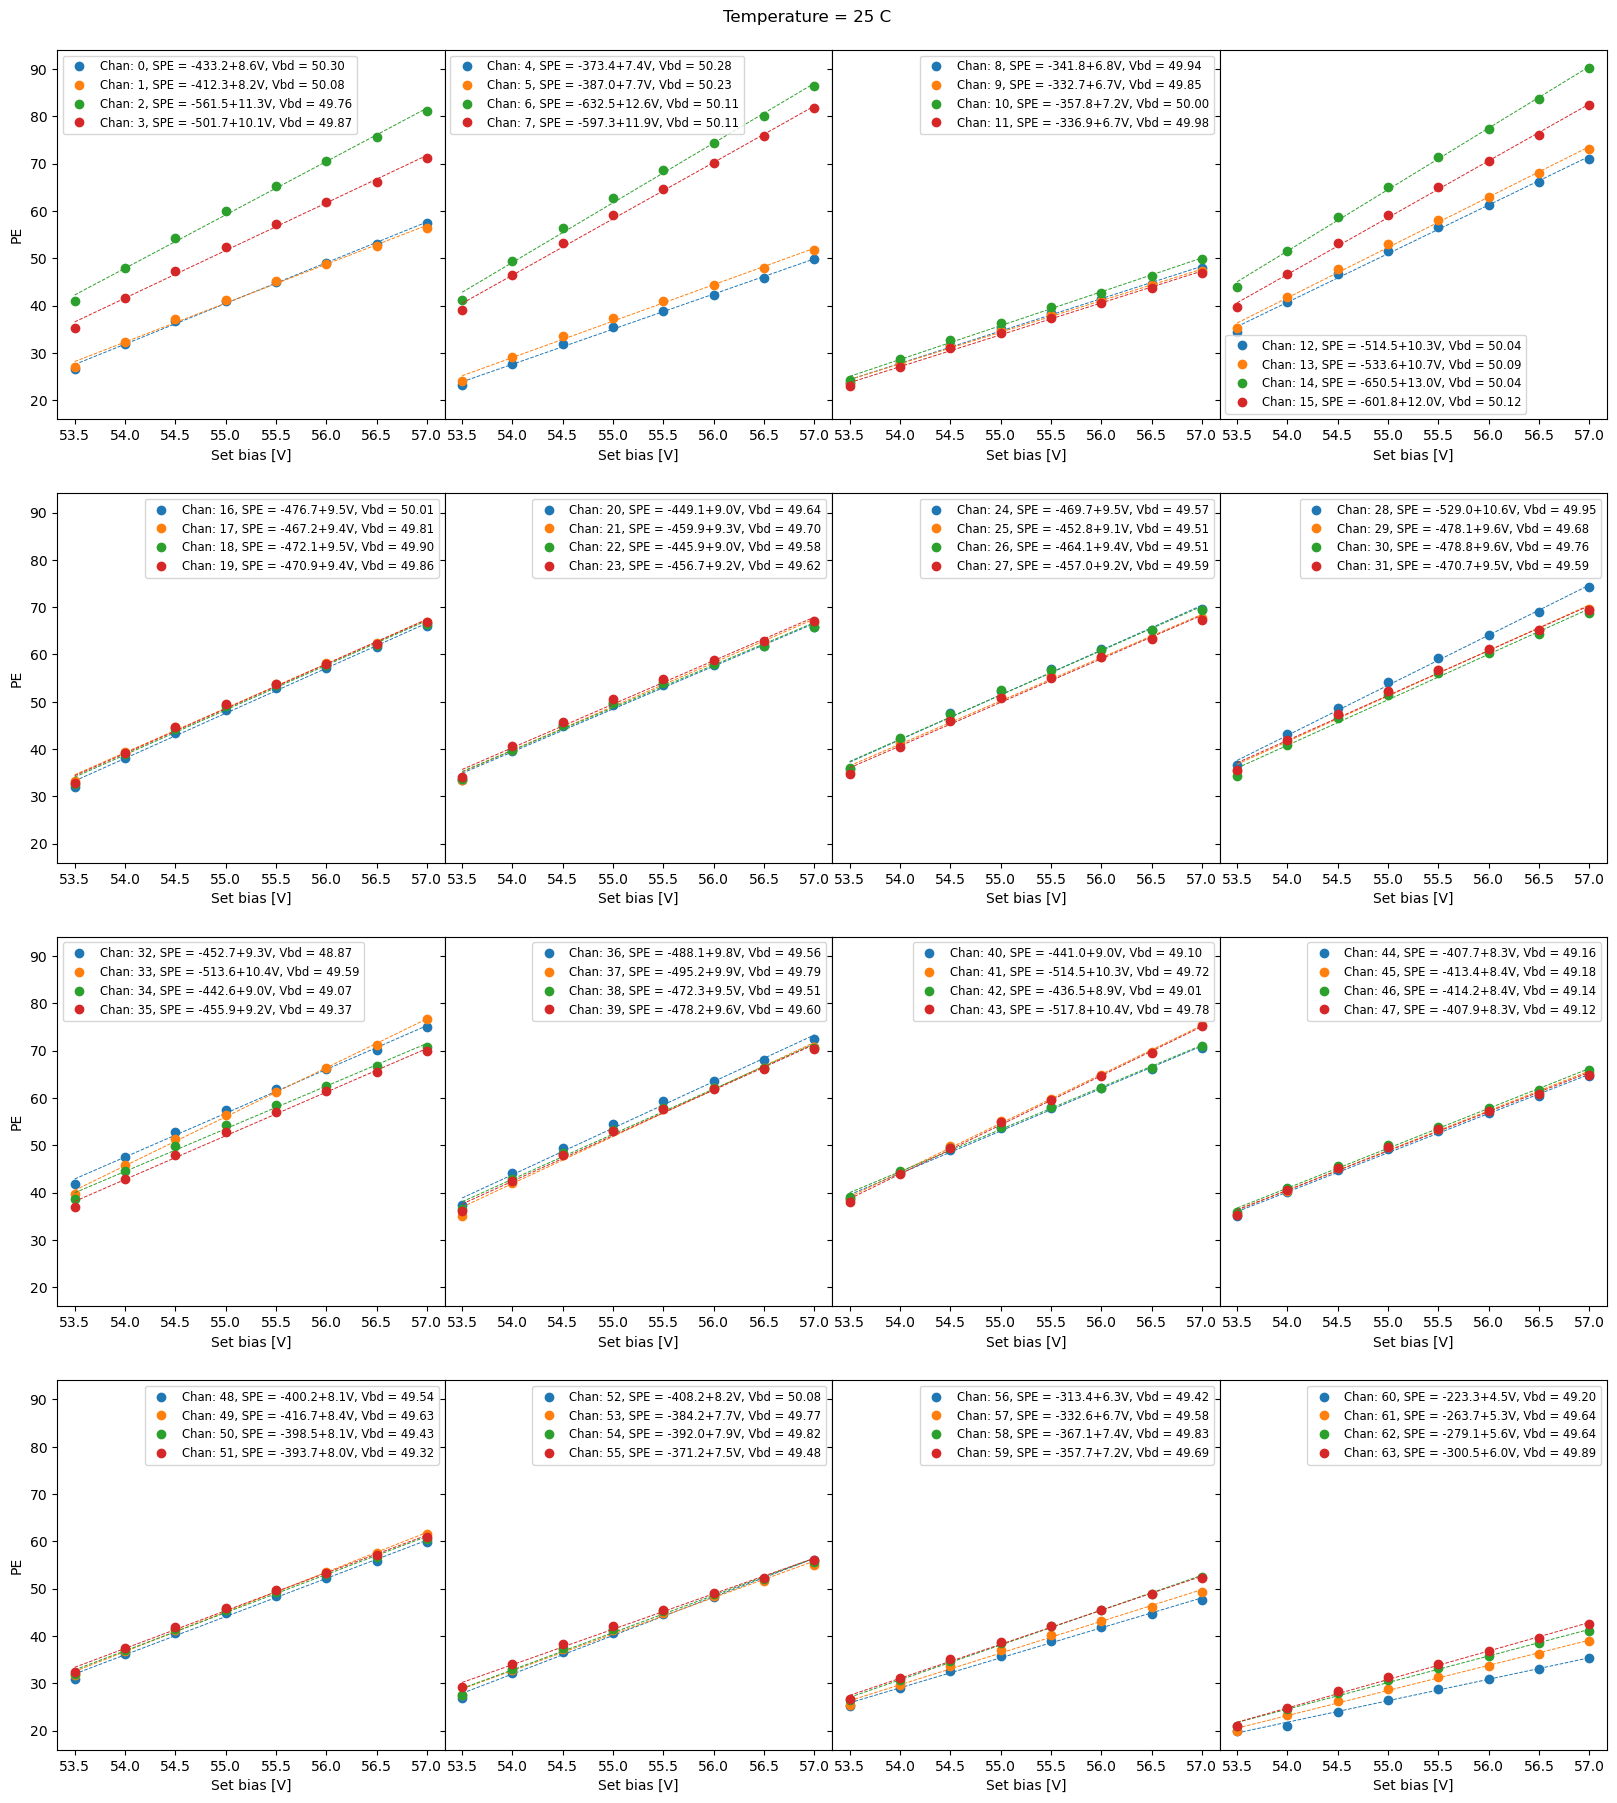

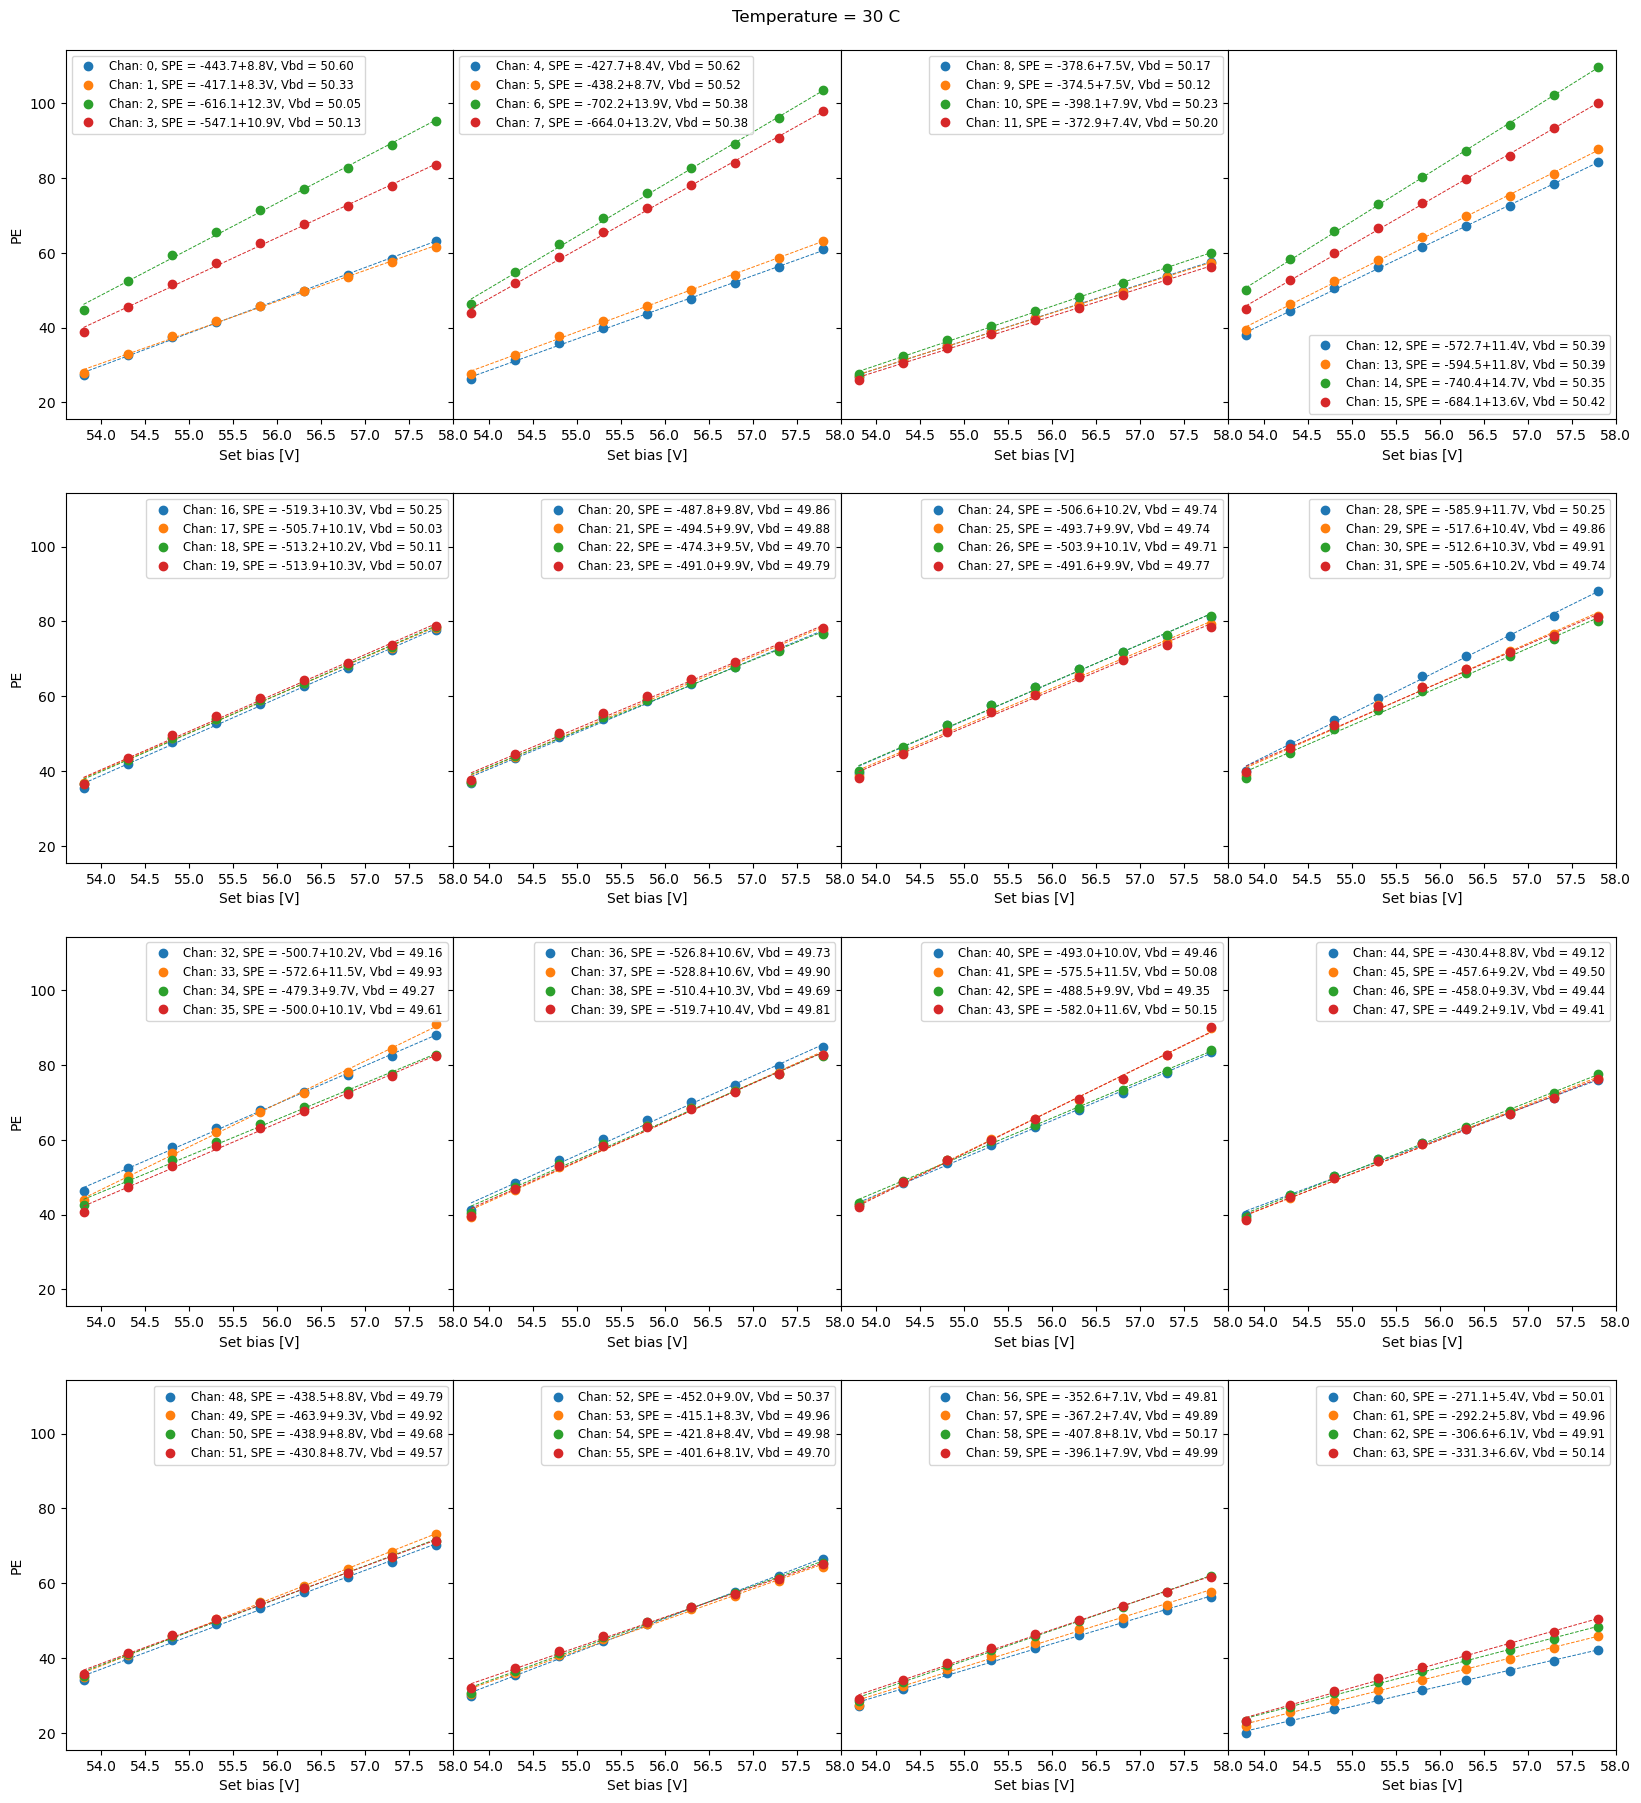

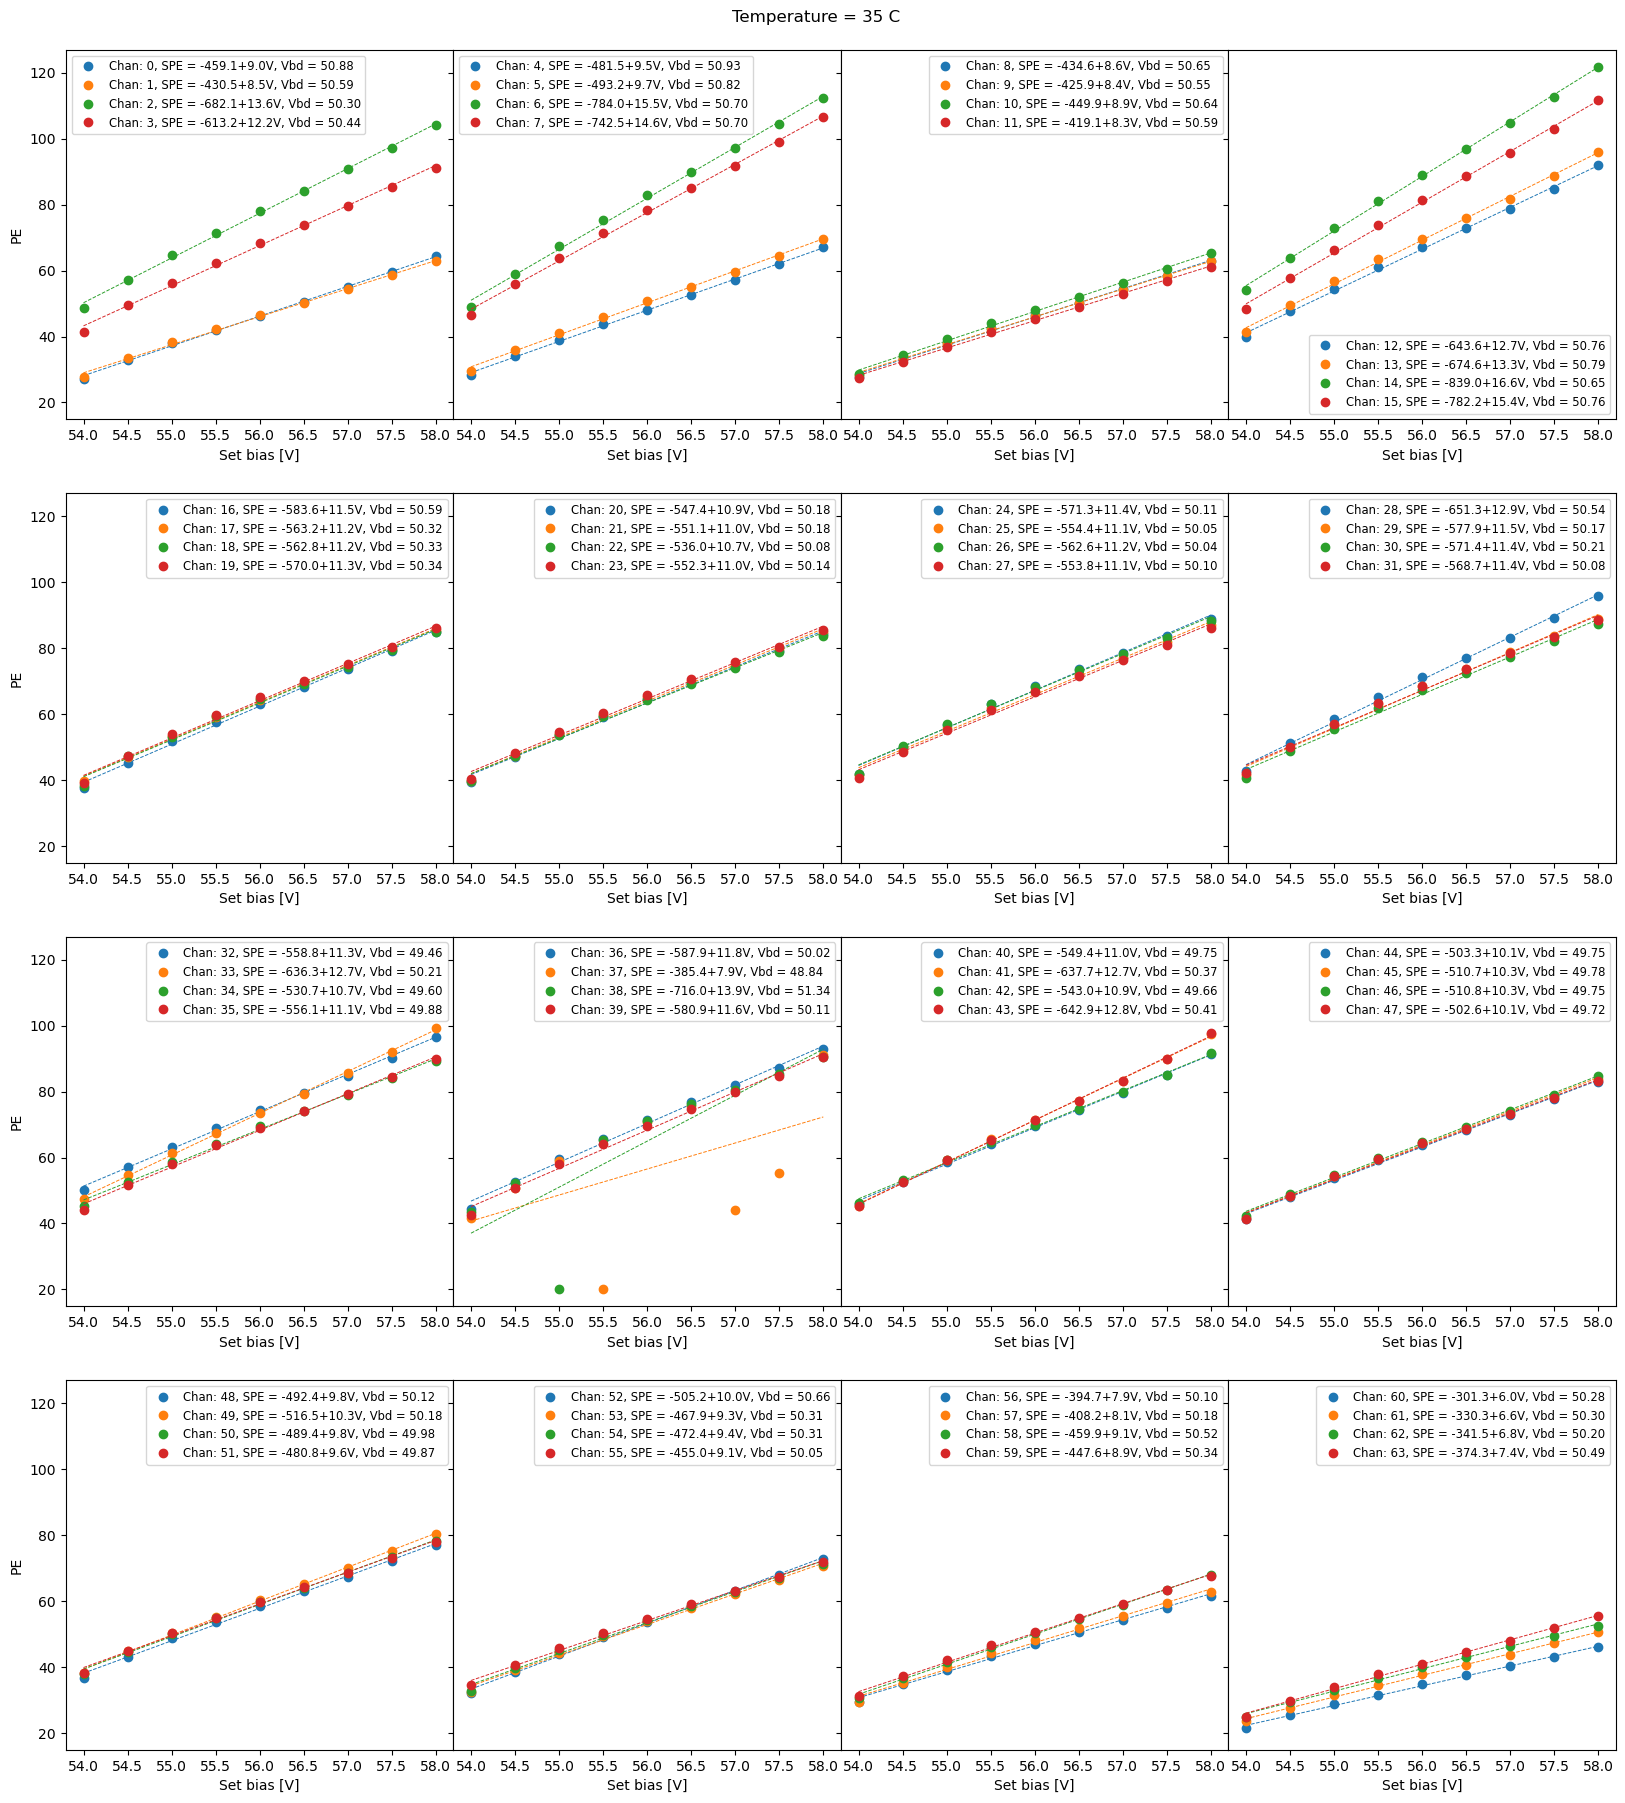

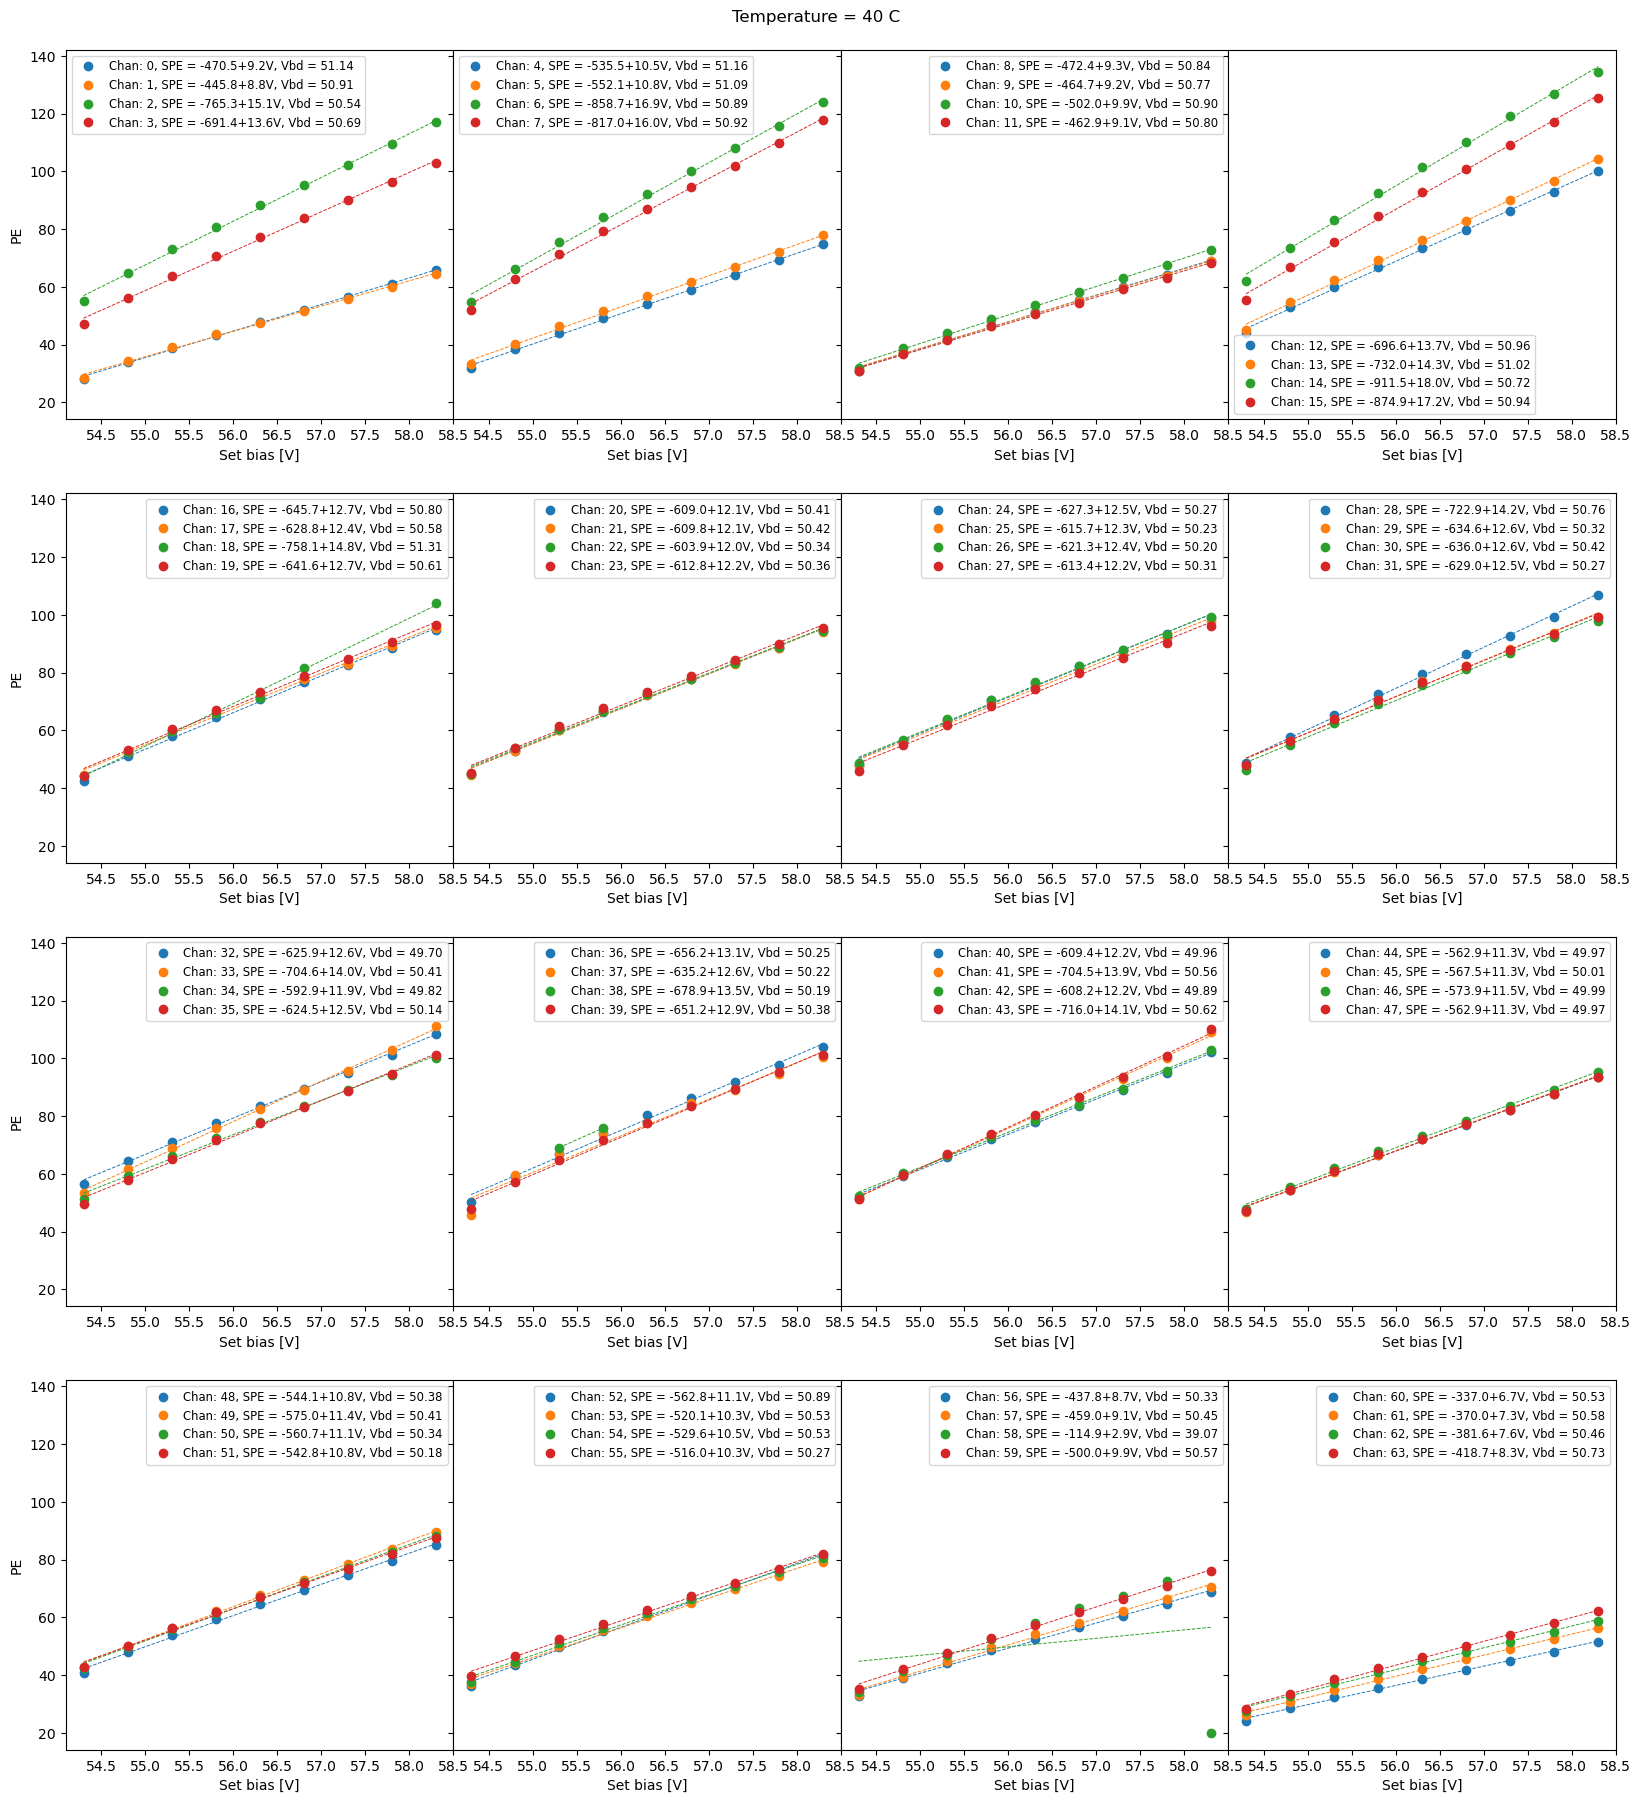

In [3]:
df = pd.DataFrame()

for idx, temp in enumerate(templist):
    processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist[idx], userunlist=True, remove=False)
    arr, arSpills = processor.getData(DATASET) # get akward array for "runSummary" tree
    
    if not np.array_equal(np.array(runlist[idx]), arr['runNumber'].to_numpy()):
        print("Input run list order and data do not match")
    
    #Mask channels which were not calibrated
    var = 'PEsTemperatureCorrected'    
    arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()
    
    df_tmp = processTemperature(arSPE, idx)
    df = pd.concat([df, df_tmp], ignore_index=True)

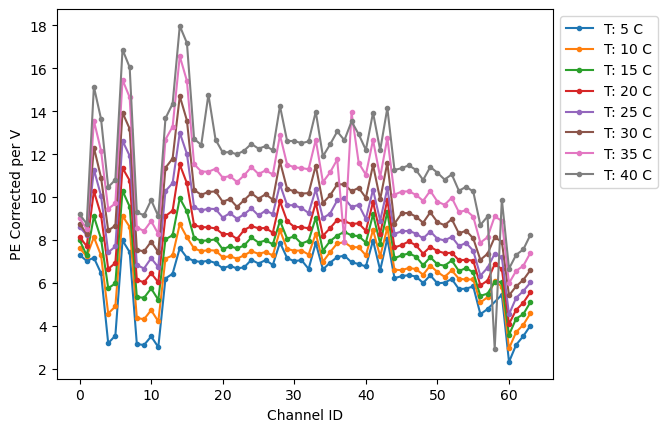

In [4]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['slope'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("PE Corrected per V");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

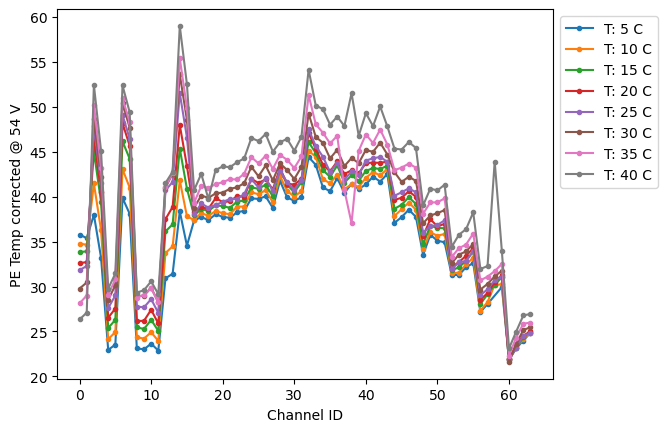

In [5]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['spe_54V_fix'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("PE Temp corrected @ 54 V");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

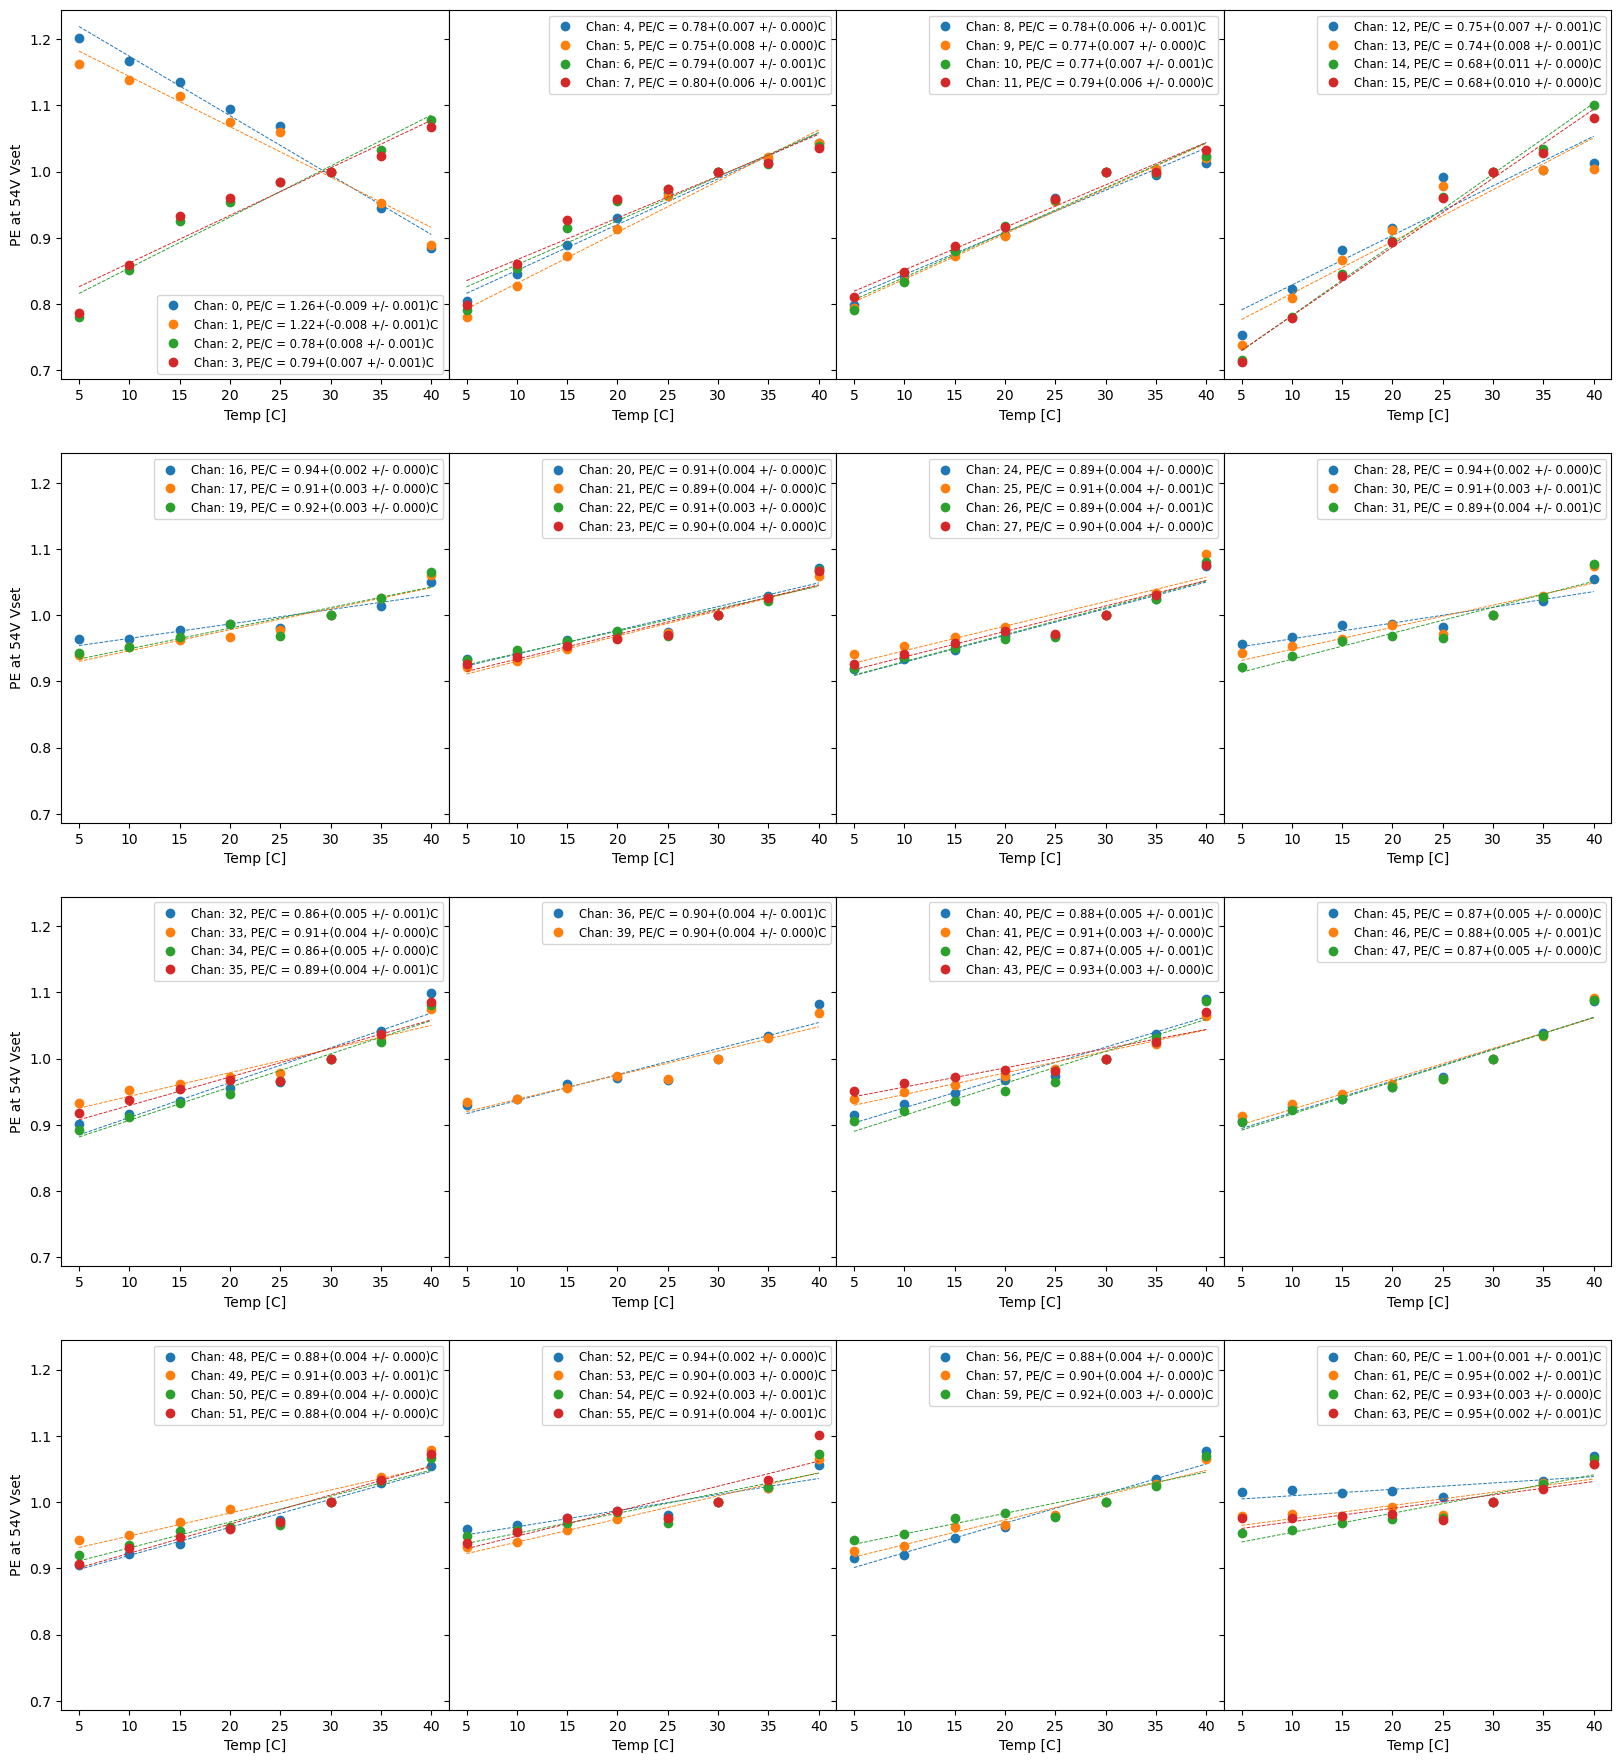

In [14]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfSPE_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("PE at 54V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in badchannels:
            continue
            
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['spe_54V_fix'].to_numpy()
        y=y/y[5]

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, PE/C = %.2f+(%.3f +/- %.3f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        dfSPE_Temp.loc[len(dfSPE_Temp)] = new_row

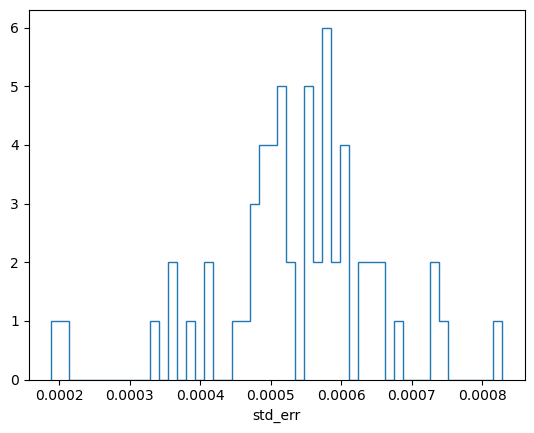

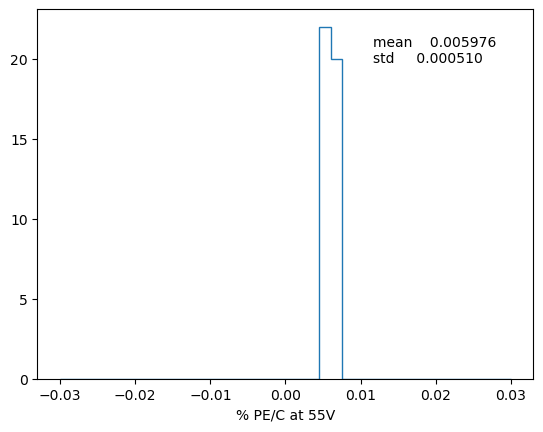

In [13]:
plt.hist(dfSPE_Temp['std_err'], histtype='step', bins=50);
plt.xlabel('std_err')
plt.figure()
plt.hist(dfSPE_Temp.query('std_err<0.3 & chan > 15')['slope'], histtype='step', bins=40, range=(-0.03,0.03));
plt.xlabel('% PE/C at 55V');
plt.figtext(0.65,0.77, dfSPE_Temp.query('std_err<0.3 & chan > 15')['slope'].describe().loc[['mean','std']].to_string());

In [8]:
pd.set_option('display.max_rows', None)
df

chan      slope  temp   intercept   r_value       p_value    std_err  \
0       0   7.307740     5 -358.837243  0.996962  5.074477e-09   1.450030   
1       1   7.028204     5 -344.132299  0.997076  4.437373e-09   1.418325   
2       2   7.177793     5 -349.611411  0.998465  4.654301e-10   1.021071   
3       3   6.451793     5 -315.174191  0.997445  2.767753e-09   1.322320   
4       4   3.196023     5 -149.641207  0.958900  4.451567e-05   5.236582   
5       5   3.551328     5 -168.232181  0.971896  1.192038e-05   4.336848   
6       6   7.982713     5 -391.205946  0.998999  1.042988e-10   0.829304   
7       7   7.437098     5 -363.501411  0.996503  8.294882e-09   1.548928   
8       8   3.163460     5 -147.710959  0.970205  1.460149e-05   4.407235   
9       9   3.108814     5 -144.868765  0.967418  1.991164e-05   4.609479   
10     10   3.512499     5 -166.035501  0.976904  6.027361e-06   3.907919   
11     11   3.017000     5 -140.048096  0.964671  2.636142e-05   4.791614   
12     12   6.209141     5 -304.377437  0.998503  4.270422e-10   1.015050   
13     13   6.434228     5 -316.024901  0.998007  1.162044e-09   1.173898   
14     14   7.629892     5 -373.645772  0.998441  4.919225e-10   1.034778   
15     15   7.176870     5 -353.002918  0.998691  2.668569e-10   0.952152   
16     16   7.026623     5 -342.077666  0.998599  3.385754e-10   0.975091   
17     17   6.980740     5 -339.222637  0.997733  1.822387e-09   1.238830   
18     18   7.038686     5 -342.684370  0.997616  2.174073e-09   1.272987   
19     19   6.930789     5 -336.224461  0.996083  1.233633e-08   1.627659   
20     20   6.688214     5 -323.393126  0.997384  3.007406e-09   1.324533   
21     21   6.797161     5 -329.401454  0.996519  8.166277e-09   1.532326   
22     22   6.680213     5 -322.452751  0.996877  5.584830e-09   1.445162   
23     23   6.730712     5 -325.034701  0.995642  1.791351e-08   1.709616   
24     24   7.078438     5 -342.422989  0.996306  1.005410e-08   1.576029   
25     25   6.908476     5 -333.294729  0.995318  2.302316e-08   1.770806   
26     26   7.065673     5 -341.501993  0.995966  1.367649e-08   1.645888   
27     27   6.841116     5 -330.668869  0.995547  1.932319e-08   1.729947   
28     28   7.885287     5 -384.028464  0.998695  2.639200e-10   0.941285   
29     29   7.160584     5 -346.751225  0.996094  1.221386e-08   1.622419   
30     30   7.015841     5 -339.313159  0.997676  1.989239e-09   1.248552   
31     31   7.068568     5 -341.766829  0.996429  8.929579e-09   1.548569   
32     32   6.656696     5 -315.037507  0.999905  2.715457e-14   0.246122   
33     33   7.864345     5 -381.126333  0.999268  3.489910e-11   0.701193   
34     34   6.632623     5 -317.132568  0.996675  6.959826e-09   1.477510   
35     35   6.945985     5 -334.466537  0.997863  1.481429e-09   1.191641   
36     36   7.208252     5 -347.176274  0.997853  1.507292e-09   1.194881   
37     37   7.274256     5 -352.388962  0.996751  6.415381e-09   1.479535   
38     38   6.964489     5 -334.644502  0.997410  2.902195e-09   1.309535   
39     39   6.884257     5 -330.889440  0.997429  2.831014e-09   1.305271   
40     40   6.770854     5 -324.254181  0.999479  1.063552e-11   0.584615   
41     41   7.977580     5 -388.555607  0.999173  5.358142e-11   0.749290   
42     42   6.599372     5 -314.675045  0.999870  8.323072e-14   0.291012   
43     43   8.064129     5 -392.933389  0.999290  3.144099e-11   0.694561   
44     44   6.225779     5 -299.095742  0.998239  7.539082e-10   1.079168   
45     45   6.319577     5 -303.517930  0.997986  1.205757e-09   1.153988   
46     46   6.364296     5 -305.115354  0.999145  6.009797e-11   0.749744   
47     47   6.302851     5 -302.600814  0.997740  1.802274e-09   1.221997   
48     48   5.999786     5 -290.461054  0.997128  4.166368e-09   1.389687   
49     49   6.358676     5 -307.613637  0.998211  7.963198e-10   1.095261   
50     50   5.982558     5 -287.952564  0.997419  2.868453e-09   1.309567   
5